In [1]:
import pandas as pd
import cptac
import cptac.pancan as pc
import scipy.stats
import seaborn as sns

import plot_utils as p
import cptac.utils as ut

cptac warning: Your version of cptac (0.9.3) is out-of-date. Latest is 0.9.4. Please run 'pip install --upgrade cptac' to update it. (<ipython-input-1-afdc2a284a10>, line 2)


In [2]:
def rename_duplicate_cols(df):
    cols = pd.Series(df.columns[:])

    for dup in cols[cols.duplicated()].unique(): 
        cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]

    # rename the columns with the cols list.
    df.columns=cols
    return df

In [3]:
def get_corr(df, dup_list):
    
    
    new = pd.DataFrame()
    
    for i in dup_list:
        ids = df.columns[df.columns.str.contains(i)].to_list()
        ids.remove(i+'_flagship')
        flag = i+'_flagship'
        
        for  ali in ids:
            test_df = both[[flag, ali]].dropna() # only plots if value for both flagship and panan
            # Create df with correlations
            first = p.wrap_pearson_corr(test_df, flag)
            new = new.append(first)
    return new

In [44]:
# correlation analysis: compares flagship values to duplicates in pancan
# df is df with both flagship and pancan values (flagship marked as '_flagship')
# dup_list is list of Patient IDs (without aliquots attached)
# y_lab is which source 

def wrap_lin_reg(df, dup_list, y_lab, wa = True):
    for i in dup_list:
        if wa == True:
            if '.N' in i:
                ids = df.columns[df.columns.str.contains(i)].to_list()
            else:
                ids = df.columns[df.columns.str.contains(i) & ~ df.columns.str.contains('\.N')].to_list()
            ids.remove(i+'_flagship')
            flag = i+'_flagship'
        else:
            flag = i+'_flagship'
            ids = [i, i+'_1']           

        for first in ids:
            plot_df = both[[flag, first]].dropna(axis = 'index', how = 'any')
            xd = plot_df[flag].min() + ((plot_df[flag].max() - plot_df[flag].min()) / 3) 
            yd = plot_df[first].max() +1


            p.plot_pearson(plot_df, flag, first, x_coor = xd, y_coor = yd, y_label = first+'_'+y_lab,
                   hue = "none", title = "", ra_stats = True,
                   show_plot = True)

In [174]:
def get_flag_df(omics_name, ca, dup_list):
    if omics_name == 'prot':
        df = ca.get_proteomics()
    
    elif omics_name == 'phospho':
        df = ca.get_phosphoproteomics()
        
    elif omics_name == 'acetyl':
        df = ca.get_acetylproteomics()
        
    if ca.get_cancer_type() == 'brca':
        df.index = [x[1:] if x[0] == 'X' else x for x in df.index]

    df = df.loc[df.index.isin(dup_list)]
    df.index = df.index+'_flagship'
    if isinstance(df.keys(), pd.core.indexes.multi.MultiIndex):
        if omics_name == 'prot':
            df = ut.reduce_multiindex(df, levels_to_drop = ['Database_ID'])
        else: # phospho and acetyl
            df = ut.reduce_multiindex(df, levels_to_drop = ['Peptide', 'Database_ID'], flatten = True)
        df = df.loc[:,~df.columns.duplicated()] # drop all duplicate prot or sites (dup once database ID dropped)
    fdf = df.T
    
    if ca.get_cancer_type() == 'luad' and omics_name == 'phospho':
        # capitalize AA sites 
        fdf.index = fdf.index.str.upper()
    
    return fdf     

In [175]:
def get_pc_df(omics_name, ca_obj, source_name, dup_list = []):
    if omics_name == 'prot':
        df = ca_obj.get_proteomics(source_name)
    
    elif omics_name == 'phospho':
        df = ca_obj.get_phosphoproteomics(source_name)
        
    all_df = pd.DataFrame()
    for i in range(0,len(dup_list)):
        new = df.loc[df.index[df.index.str.contains(dup_list[i])]]
        all_df = all_df.append(new)
    if omics_name == 'prot':
        df = ut.reduce_multiindex(all_df, levels_to_drop=[1], flatten = True)
    else:
        df = ut.reduce_multiindex(all_df, levels_to_drop = [2,3], flatten = True)
    df = df.loc[:,~df.columns.duplicated()]
    df = df.T
        
    #df.index = df.index.str.upper()   
    df = rename_duplicate_cols(df)
        
    return df

# Brca

In [151]:
b = pc.PancanBrca()
brca = cptac.Brca(version='3.1.1')

cptac warning: Old brca data version. Latest is 5.4. This is 3.1.1. (<ipython-input-151-04548f4bd6d7>, line 2)


In [168]:
# show which omics has duplicates
ca = b
source_name = 'umich'
prot = ca.get_proteomics(source_name)
phos = ca.get_phosphoproteomics(source_name)
prot = ut.reduce_multiindex(prot, levels_to_drop=[1], flatten = True)
prot

cptac warning: Due to dropping the specified levels, dataframe now has 1593 duplicated column headers. (<ipython-input-168-d4b58bd3d0f7>, line 6)
cptac warning: You tried to flatten a column index that didn't have multiple levels, so we didn't actually change anything. (<ipython-input-168-d4b58bd3d0f7>, line 6)


Name,ARF5,M6PR,ESRRA,FKBP4,NDUFAF7,FUCA2,DBNDD1,SEMA3F,CFTR,CYP51A1,...,DDHD1,WIZ,GBF1,APOA5,WIZ,LDB1,WIZ,RFX7,SWSAP1,SVIL
Patient_ID,,,,,,,,,,,,,,,,,,,,,
01BR001,0.012367,-0.945999,NaN,-0.478170,1.135840,-0.512706,0.750335,-0.274824,NaN,-0.278244,...,-0.649127,-0.580869,-0.226667,NaN,NaN,-0.676185,-0.068202,-0.078207,-0.328420,NaN
01BR008,-0.514386,0.462307,0.230124,-0.555968,0.491366,-0.656034,-1.220890,-0.369282,-1.036441,-0.059327,...,0.632221,NaN,0.032873,NaN,NaN,-0.015459,0.227424,0.325643,-0.606240,NaN
01BR009,-0.210782,-0.085055,0.380296,-0.389491,1.255391,-0.608007,-0.231318,0.092870,-1.505195,0.206595,...,0.450818,NaN,-0.341503,NaN,NaN,-0.220239,0.125092,0.365397,-0.167392,NaN
01BR010,0.105457,0.351335,-0.322798,-0.821610,0.241406,-0.500140,-0.137824,0.113791,NaN,0.498314,...,-0.423470,NaN,0.360900,NaN,NaN,-0.451556,-0.098897,0.208643,-0.729096,0.670307
01BR015,-0.509298,-0.874164,NaN,-0.113804,-0.131347,-0.412813,0.262210,0.042333,NaN,-0.657666,...,0.406016,-0.493869,-0.192847,NaN,NaN,0.083639,0.966976,-0.012664,0.081968,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21BR010.2,0.451256,-0.113599,-0.497360,-0.073096,0.037491,0.569117,0.119570,0.332707,NaN,-0.305222,...,-0.518178,NaN,0.227157,NaN,NaN,0.060786,-0.165799,-0.068334,-0.311446,0.602422
22BR005,-0.549542,0.134236,NaN,0.580773,-0.080663,-0.056509,-0.148632,0.260986,NaN,-0.348578,...,0.791937,NaN,0.171712,NaN,NaN,0.083980,-0.200083,0.155198,NaN,0.456801
22BR006,0.336092,0.125742,NaN,-0.360510,0.086199,0.470607,-0.515990,-0.162247,1.003075,0.342987,...,-0.080755,NaN,0.174904,-0.353412,NaN,-0.013793,-0.253829,-0.117960,NaN,1.094966


In [155]:
# From prosp-brca-all-samples.txt
rep = ['11BR031', '11BR053', '11BR036', '11BR060', '14BR005', '11BR011', '21BR010'] # 2 replicates for 11BR036

norm = ['11BR074', '11BR073', '20BR007', '21BR010', '11BR017', '05BR029', '18BR003', '11BR030',
        '01BR027','11BR025', '11BR047', '11BR028', '11BR020', '20BR008', '11BR024', '11BR023',
        '11BR015', '11BR006']

print('IDs with replicates (all tumor):', len(rep))
print('IDs with a normal sample taken:', len(norm))

IDs with replicates (all tumor): 7
IDs with a normal sample taken: 18


In [194]:
#omics = 'prot'
omics = 'phospho'
nr_list = rep # choose norm or rep
pcdf = get_pc_df(omics, b, 'umich', dup_list = nr_list)
pcdf

cptac warning: Due to dropping the specified levels, dataframe now has 14291 duplicated column headers. (<ipython-input-175-a57c5c24fe84>, line 15)


Patient_ID,11BR031,11BR031.1,11BR053,11BR053.1,11BR036,11BR036.1,11BR036.2,11BR060,11BR060.1,14BR005,14BR005.1,11BR011,11BR011.1,21BR010,21BR010.1,21BR010.2
Name,,,,,,,,,,,,,,,,
ARF5_S137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.263792,0.486741,0.729312,NaN,NaN,NaN,NaN,NaN
M6PR_S267,NaN,-0.279121,-0.679338,-0.955813,0.357288,0.538957,-0.052100,0.620268,1.152407,0.559012,0.819807,-0.401364,-0.324690,-0.149555,-0.333804,-0.372943
ESRRA_S22,NaN,NaN,NaN,NaN,NaN,-0.009799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ESRRA_S19S22,NaN,NaN,NaN,NaN,NaN,NaN,0.783193,NaN,1.470776,NaN,0.170736,NaN,-0.593049,NaN,-0.571210,-0.827940
ESRRA_S22S26S27,NaN,NaN,NaN,NaN,NaN,NaN,0.359119,NaN,NaN,0.158472,NaN,-0.147965,-0.481334,NaN,NaN,-0.274312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LDB1_S388,NaN,NaN,NaN,NaN,NaN,NaN,-0.795465,NaN,NaN,NaN,NaN,NaN,-0.701123,NaN,-0.690497,0.195022
LDB1_S377S381,NaN,-0.084976,0.701517,NaN,NaN,NaN,0.051375,NaN,NaN,NaN,NaN,NaN,0.547784,0.277522,NaN,0.703883
LDB1_S381S388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.654668,NaN,0.978248,NaN,NaN,NaN,NaN,NaN


In [195]:
fdf = get_flag_df(omics, brca, nr_list)
fdf

cptac warning: Due to dropping the specified levels, dataframe now has 356 duplicated column headers. (<ipython-input-174-b2b0f2ee8e36>, line 20)


,11BR011_flagship,11BR031_flagship,11BR036_flagship,11BR053_flagship,11BR060_flagship,14BR005_flagship,21BR010_flagship
Name,,,,,,,
A2M_S710,-0.7823,NaN,-1.8667,NaN,NaN,NaN,-0.7266
AAAS_S495,-0.0333,-1.2150,0.7550,0.0881,0.3567,1.4258,-0.1201
AAAS_S541,0.8057,-1.4544,NaN,NaN,NaN,NaN,-0.1477
AAED1_S12,NaN,2.2767,0.3709,-0.7341,-0.2311,-1.1443,1.8818
AAGAB_S310S311,-0.4050,-0.1155,-1.5758,-0.1626,-0.4987,0.6834,0.8338
...,...,...,...,...,...,...,...
ZZZ3_S397,-0.5822,0.2661,-0.0844,-0.0911,-0.0274,0.2350,0.9095
ZZZ3_S397T428N429,-0.4975,-0.2369,1.1205,-0.3594,0.4413,0.1369,0.3844
ZZZ3_S606,-0.3742,-0.0397,0.3685,-0.3860,0.3115,1.0351,0.1160


In [196]:
both = fdf.join(pcdf, how = 'inner')
both = both.dropna(axis = 1, how = 'all')
both

,11BR011_flagship,11BR031_flagship,11BR036_flagship,11BR053_flagship,11BR060_flagship,14BR005_flagship,21BR010_flagship,11BR031,11BR031.1,11BR053,...,11BR036.2,11BR060,11BR060.1,14BR005,14BR005.1,11BR011,11BR011.1,21BR010,21BR010.1,21BR010.2
Name,,,,,,,,,,,,,,,,,,,,,
A2M_S710,-0.7823,NaN,-1.8667,NaN,NaN,NaN,-0.7266,NaN,NaN,-0.571122,...,-1.369099,NaN,NaN,NaN,NaN,0.048908,-1.040561,0.019065,1.522059,-0.304407
AAAS_S495,-0.0333,-1.2150,0.7550,0.0881,0.3567,1.4258,-0.1201,NaN,NaN,NaN,...,-0.972056,NaN,-0.092869,NaN,1.095514,NaN,-2.001769,NaN,0.160431,-0.124794
AAAS_S541,0.8057,-1.4544,NaN,NaN,NaN,NaN,-0.1477,NaN,NaN,NaN,...,0.958242,NaN,NaN,NaN,NaN,NaN,1.267053,NaN,NaN,0.622669
AAGAB_S310S311,-0.4050,-0.1155,-1.5758,-0.1626,-0.4987,0.6834,0.8338,NaN,0.008780,0.152134,...,-0.796778,-0.107765,-0.035848,0.331721,0.640573,-0.135760,-0.074124,0.610358,0.333095,0.557434
AAGAB_S311,1.4892,1.0646,-0.4011,-0.6528,0.4318,0.2126,0.2280,NaN,0.441750,-0.988554,...,-0.527293,-0.795344,0.830309,0.297349,-0.009610,2.136472,3.005288,-1.243206,-1.411388,-0.288704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZZEF1_S1537S1540,-1.5154,NaN,0.4374,-1.8724,0.0503,-0.8930,0.2505,NaN,0.606180,NaN,...,0.293447,0.077871,0.142858,-0.331167,-0.625149,-0.510516,-1.086360,NaN,1.295590,0.096017
ZZEF1_S1540,-1.8452,1.9420,-1.3645,NaN,0.6994,1.6090,-0.5268,1.305242,1.295568,NaN,...,-0.588373,0.385259,0.394760,0.527280,1.101978,-0.843026,-1.534096,NaN,0.295535,-0.154995
ZZEF1_S240,NaN,-0.5400,0.9832,NaN,0.9677,-0.1163,NaN,NaN,0.139851,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [197]:
# TypeError: arg must be a list, tuple, 1-d array, or Series
# can occur if column contains on NaN (like with PDC phospho for brca)
for col in both.columns:
    both[col] = pd.to_numeric(both[col])  

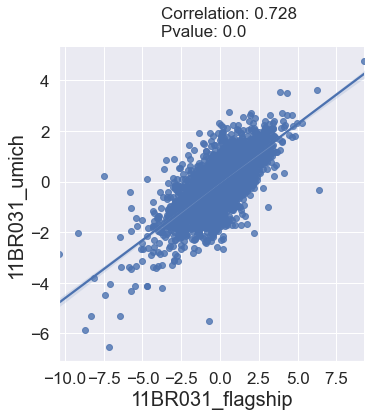

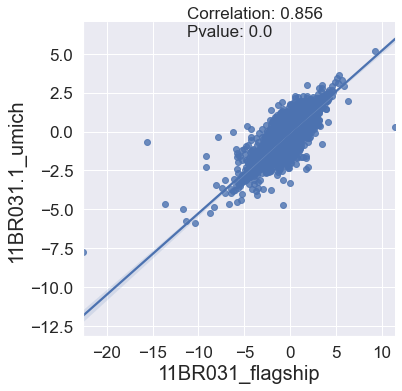

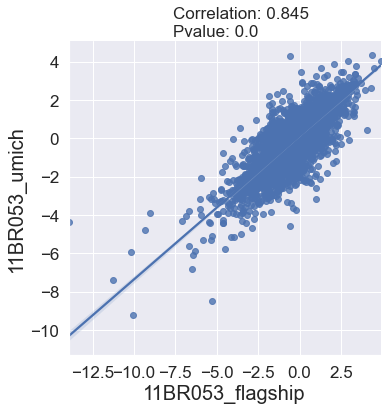

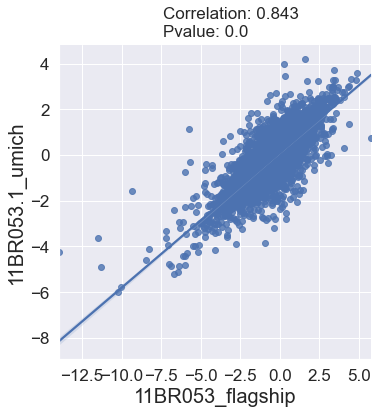

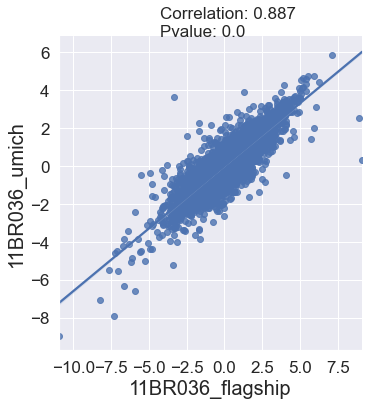

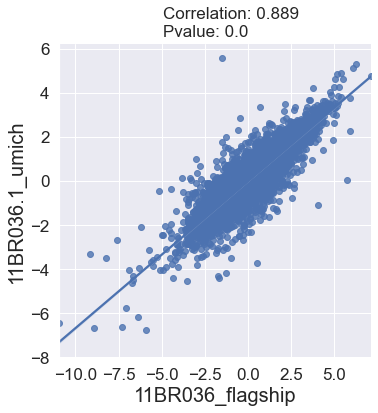

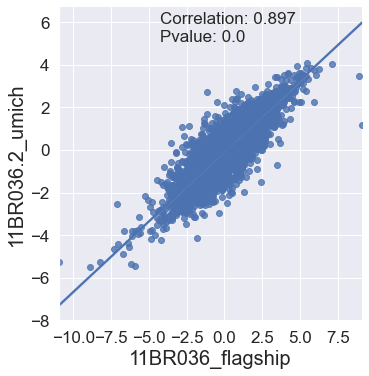

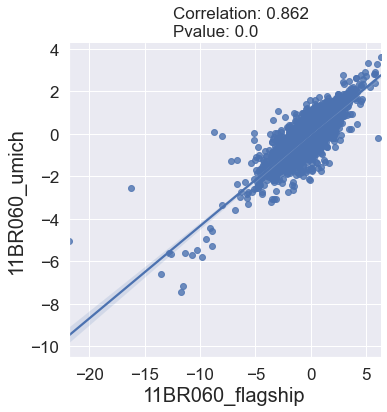

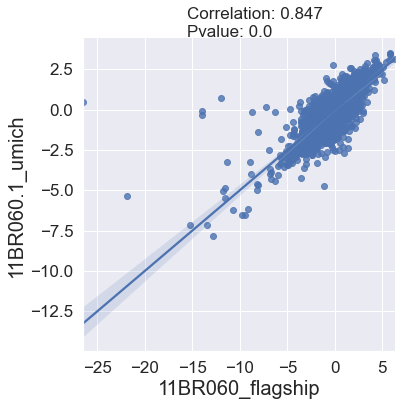

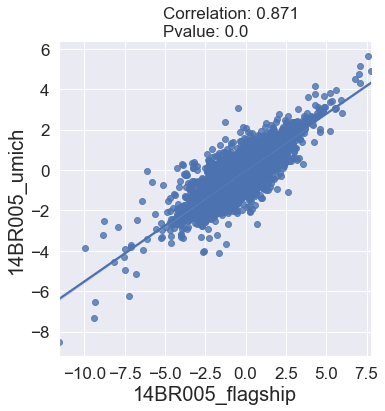

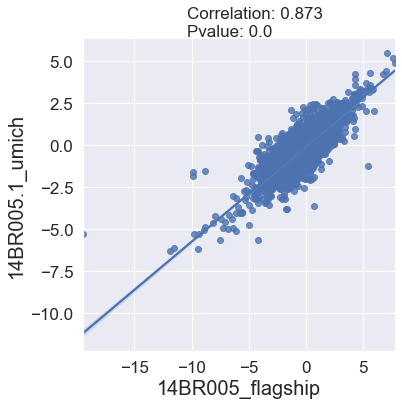

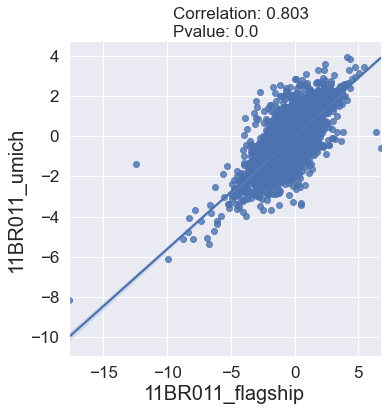

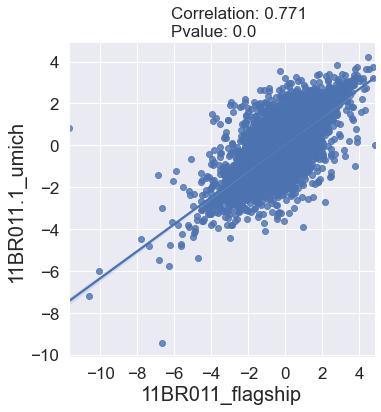

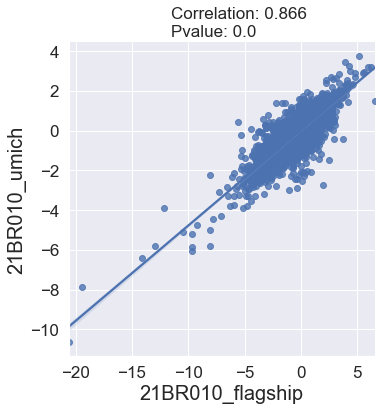

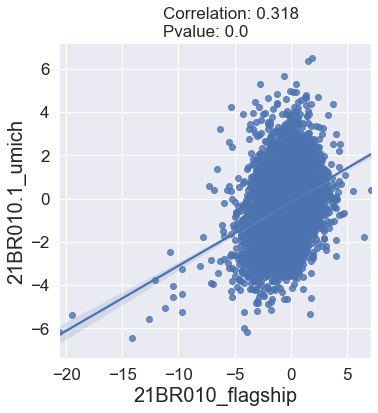

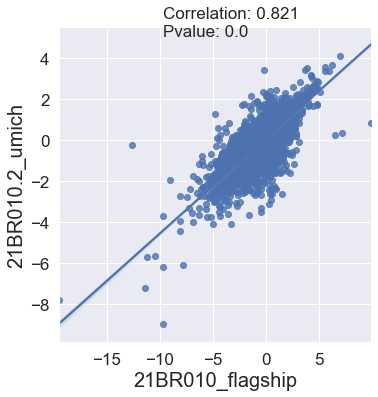

In [198]:
wrap_lin_reg(both, nr_list, y_lab = source_name)

In [181]:
# print(omics)
get_corr(both, nr_list)

,Comparison,Correlation,P_value
0,11BR031,0.896451,0.000000e+00
0,11BR031.1,0.870193,0.000000e+00
0,11BR053,0.708342,0.000000e+00
0,11BR053.1,0.706602,0.000000e+00
0,11BR036,0.918915,0.000000e+00
0,11BR036.1,0.918593,0.000000e+00
0,11BR036.2,0.918963,0.000000e+00
0,11BR060,0.888610,0.000000e+00
0,11BR060.1,0.892067,0.000000e+00
0,14BR005,0.895053,0.000000e+00


# Hnscc

Check correlation of replicates with each other (confirmed same tissue type).

In [97]:
h = pc.PancanHnscc()
hnscc = cptac.Hnscc()

In [182]:
# show which omics has duplicates
ca = h
source_name = 'umich'
prot = ca.get_proteomics(source_name)
phos = ca.get_phosphoproteomics(source_name)
print('prot:', prot.loc[prot.index.str.contains('duplicate')].index.to_list())
print('phospho:', phos.loc[phos.index.str.contains('duplicate')].index.to_list())

prot: ['C3L-02617-T-duplicate', 'C3L-00994-N-duplicate', 'C3L-02617-N-duplicate', 'C3L-02617-N-duplicate2']
phospho: ['C3L-02617-duplicate', 'C3L-00994-N-duplicate', 'C3L-02617-N-duplicate', 'C3L-02617-N-duplicate2']


In [183]:
#omics = 'prot'
omics = 'phospho'

if omics == 'prot':
    df = prot
    df = df.reset_index()
    dup_list = df.loc[df.Patient_ID.str.contains('duplicate')].Patient_ID.to_list()
    df = df.set_index('Patient_ID')
    dup_list = dup_list + ['C3L-02617','C3L-02617.N','C3L-00994.N']
    df = df.loc[df.index.isin(dup_list)]
    df = ut.reduce_multiindex(df, levels_to_drop = [1], flatten=True)
    df = df.loc[:,~df.columns.duplicated()] # drop all duplicate prot or sites (dup once database ID dropped)
    df = df.T
    pcdf = rename_duplicate_cols(df)

elif omics == 'phospho': 
    df = phos
    df.index.name = 'Patient_ID'
    df = df.reset_index()
    dup_list = df.loc[df['Patient_ID'].str.contains('duplicate')].Patient_ID.to_list()
    df = df.set_index('Patient_ID')
    dup_list
    dup_list = dup_list + ['C3L-02617','C3L-02617.N','C3L-00994.N']
    df = df.loc[df.index.isin(dup_list)]
    df = ut.reduce_multiindex(df, levels_to_drop = [2,3], flatten=True)
    df = df.loc[:,~df.columns.duplicated()] # drop all duplicate prot or sites (dup once database ID dropped)
    df = df.T
    pcdf = rename_duplicate_cols(df)

print(omics)    
pcdf

cptac warning: Due to dropping the specified levels, dataframe now has 8673 duplicated column headers. (<ipython-input-183-09d614efb7c9>, line 25)


phospho


Patient_ID,C3L-02617-duplicate,C3L-02617.N,C3L-00994.N,C3L-02617,C3L-00994-N-duplicate,C3L-02617-N-duplicate,C3L-02617-N-duplicate2
Name,,,,,,,
M6PR_S267,0.319666,0.308527,-0.693767,-0.169315,-0.722139,0.136739,-0.135490
ESRRA_S19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ESRRA_S22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ESRRA_S19S22,NaN,NaN,0.061645,NaN,-0.042662,0.114082,0.204016
ESRRA_S22S26,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
LDB1_S377,NaN,NaN,NaN,NaN,0.564402,1.193185,-0.051944
LDB1_S388,0.242037,0.825815,0.922166,NaN,NaN,NaN,NaN
LDB1_S410,0.240672,-1.444394,-0.118792,0.849334,-0.575125,-0.050985,0.280245


['C3L-02617', 'C3L-02617-duplicate']


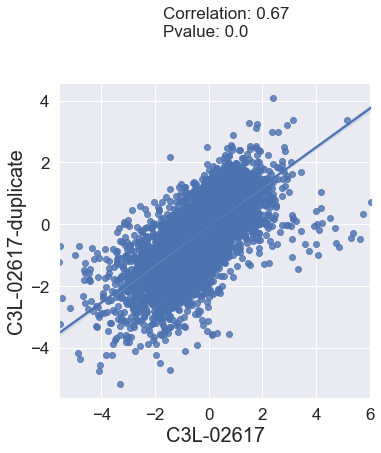

['C3L-00994-N-duplicate', 'C3L-00994.N']


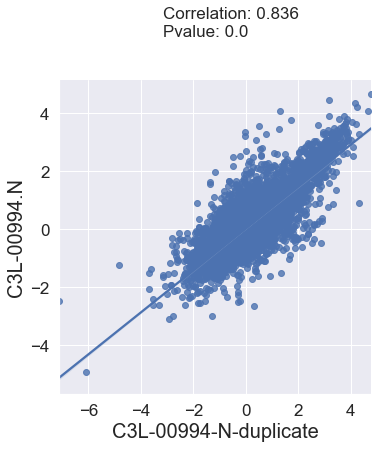

['C3L-02617-N-duplicate', 'C3L-02617-N-duplicate2', 'C3L-02617.N']


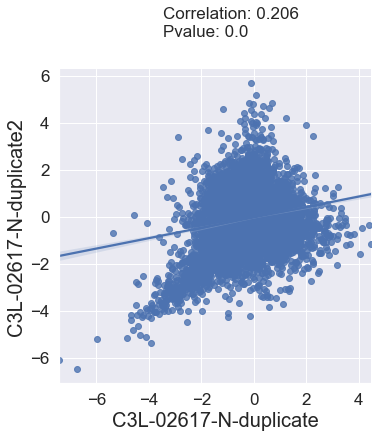

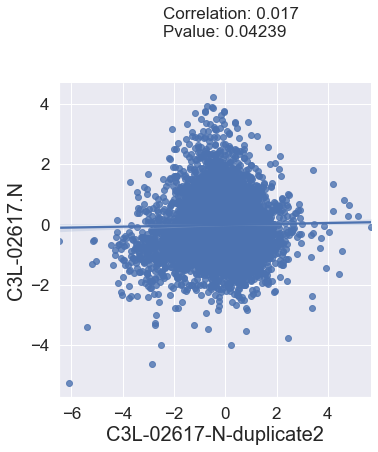

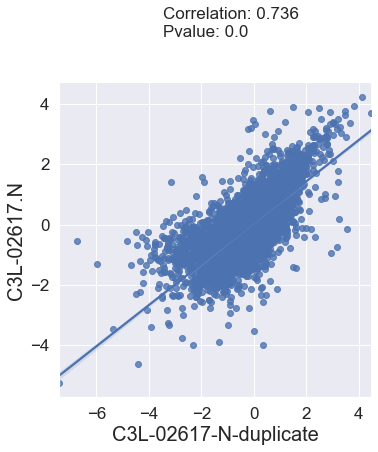

In [184]:
# compare correlations between pancan duplicates

df = pcdf
for col in df.columns:
    df[col] = pd.to_numeric(df[col])  

hnscc_dup = ['C3L-02617', 'C3L-00994.N', 'C3L-02617.N'] 

for i in hnscc_dup:
    if '.N' in i:
        dups = df.columns[df.columns.str.contains(i)].to_list()
    else:
        dups = df.columns[df.columns.str.contains(i) & ~ df.columns.str.contains('N')].to_list()
    
    dups.sort() # sort for right order for tumor 
    print(dups)

    first = dups[0]
    second = dups[1]
    
    plot_df = df[[first, second]].dropna(axis = 'index', how = 'any')
    xd = plot_df[first].min() + ((plot_df[first].max() - plot_df[first].min()) / 3) 
    yd = plot_df[second].max() + 2

    p.plot_pearson(plot_df, first, second, x_coor = xd, y_coor = yd, 
           hue = "none", title = "", ra_stats = True,
           show_plot = True)
        
    if len(dups) == 3:
        third = dups[2]
        plot_df2 = df[[second, third]].dropna(axis = 'index', how = 'any')
        xd = plot_df2[second].min() + ((plot_df2[second].max() - plot_df2[second].min()) / 3)
        yd = plot_df2[third].max() + 2                       
        p.plot_pearson(plot_df2, second, third, x_coor = xd, y_coor = yd,
               hue = "none", title = "", ra_stats = True,
               show_plot = True)
        
        plot_df3 = df[[first, third]].dropna(axis = 'index', how = 'any')
        xd = plot_df3[first].min() + ((plot_df3[first].max() - plot_df3[first].min()) / 3)
        yd = plot_df3[third].max() + 2
        p.plot_pearson(plot_df3, first, third, x_coor = xd, y_coor = yd,
               hue = "none", title = "", ra_stats = True,
               show_plot = True)

In [185]:
# Flagship
print(omics)
hnscc_dup = ['C3L-02617', 'C3L-00994.N', 'C3L-02617.N']
fdf = get_flag_df(omics, hnscc, hnscc_dup)
fdf

phospho


cptac warning: Due to dropping the specified levels, dataframe now has 6904 duplicated column headers. (<ipython-input-174-b2b0f2ee8e36>, line 20)


Patient_ID,C3L-02617_flagship,C3L-00994.N_flagship,C3L-02617.N_flagship
Name,,,
A2M_S710,NaN,NaN,15.412727
A2M_S928,NaN,NaN,NaN
A2ML1_S658,NaN,NaN,NaN
A2ML1_S698,NaN,NaN,NaN
AAAS_S462,24.627331,23.12606,23.729201
...,...,...,...
ZZZ3_S381T388,NaN,NaN,NaN
ZZZ3_S391,22.452369,20.65330,20.989371
ZZZ3_S396,NaN,NaN,NaN


In [186]:
both = fdf.join(pcdf, how = 'inner')
both.head()
both

Patient_ID,C3L-02617_flagship,C3L-00994.N_flagship,C3L-02617.N_flagship,C3L-02617-duplicate,C3L-02617.N,C3L-00994.N,C3L-02617,C3L-00994-N-duplicate,C3L-02617-N-duplicate,C3L-02617-N-duplicate2
Name,,,,,,,,,,
A2M_S710,NaN,NaN,15.412727,-0.020076,-0.008653,NaN,NaN,NaN,NaN,NaN
A2M_S928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2ML1_S658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2ML1_S698,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAK1_S20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.244261,0.223093,-0.054648
...,...,...,...,...,...,...,...,...,...,...
ZZEF1_S240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.325316,-0.542617,0.433388
ZZEF1_S2444,21.92667,22.209344,22.246455,NaN,NaN,0.379277,0.082215,1.471772,0.217617,-0.008783
ZZEF1_T1477,NaN,17.194959,17.449300,0.459744,-0.170553,-0.409372,NaN,NaN,NaN,NaN


In [187]:
for col in both.columns:
    both[col] = pd.to_numeric(both[col])  

phospho


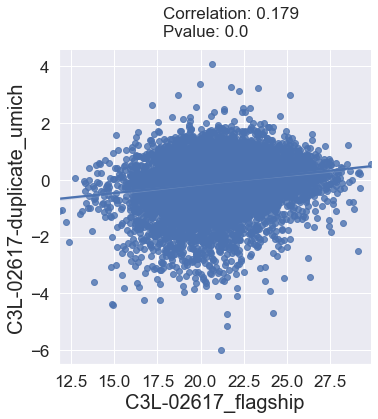

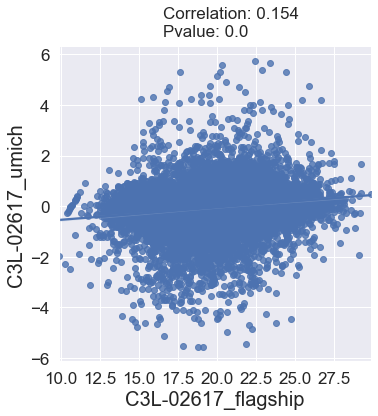

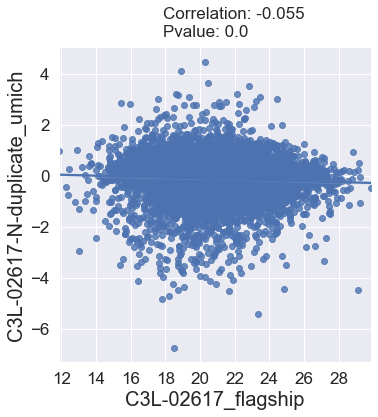

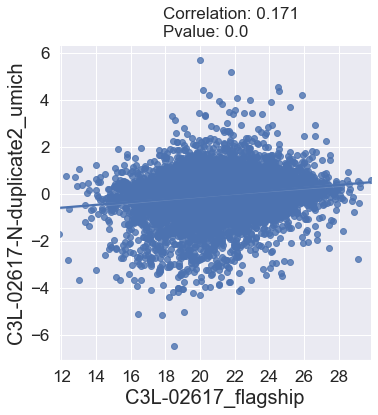

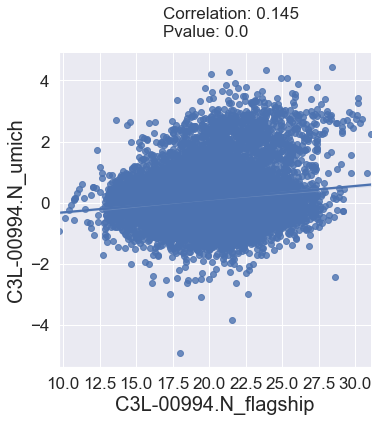

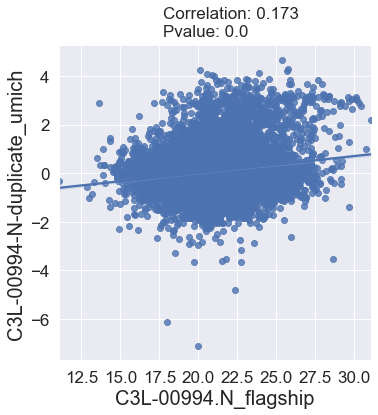

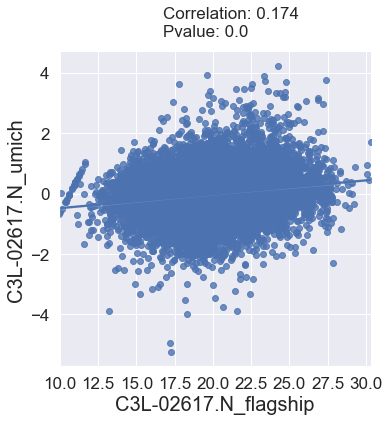

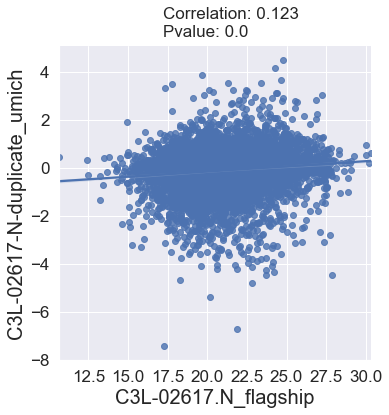

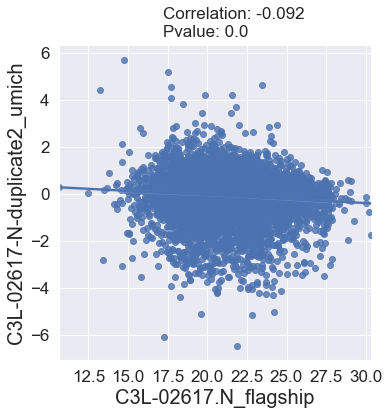

In [188]:
# compare to flagship - doesn't correlate well
print(omics)
wrap_lin_reg(both, hnscc_dup, y_lab = source_name)

# Luad

In [96]:
l = pc.PancanLuad()
luad = cptac.Luad()

In [189]:
# show which omics has duplicates
ca = l
source_name = 'umich'
prot = ca.get_proteomics(source_name)
phos = ca.get_phosphoproteomics(source_name)
print('prot:', set(prot.index.duplicated()), list(prot.index[prot.index.duplicated()]))
print('phospho:', set(phos.index.duplicated()), list(phos.index[phos.index.duplicated()]))

prot: {False} []
phospho: {False} []


In [190]:
omics = 'phospho'
dup_list = ['C3N-02379', 'C3N-02587']
pcdf = get_pc_df(omics, l, 'umich', dup_list)
pcdf

cptac warning: Due to dropping the specified levels, dataframe now has 10434 duplicated column headers. (<ipython-input-175-a57c5c24fe84>, line 15)


,C3N-02379,C3N-02379.N,C3N-02587,C3N-02587.N
Name,,,,
ARF5_S137,NaN,NaN,NaN,NaN
M6PR_S267,-0.521979,-0.097239,0.344673,0.321462
ESRRA_S19S22,-0.151020,NaN,NaN,NaN
ESRRA_S22S26S27,NaN,NaN,0.360497,-0.005055
ESRRA_S26S27T29,NaN,NaN,NaN,NaN
...,...,...,...,...
TSGA10_S39,NaN,NaN,NaN,NaN
TSGA10_S321,-0.719322,NaN,NaN,NaN
TSGA10_S391,NaN,NaN,NaN,NaN


In [191]:
dup_list = ['C3N-02379', 'C3N-02587']
fdf = get_flag_df(omics, luad, dup_list)
fdf

cptac warning: Due to dropping the specified levels, dataframe now has 313 duplicated column headers. (<ipython-input-174-b2b0f2ee8e36>, line 20)


Patient_ID,C3N-02379_flagship,C3N-02587_flagship
Name,,
AAAS_S495,1.6253,-0.5442
AAAS_S541,0.1938,NaN
AAED1_S12,-0.1474,0.4084
AAGAB_S310S311,0.9514,0.1498
AAGAB_S311,0.3344,0.7129
...,...,...
ZZZ3_S113,1.1984,1.0357
ZZZ3_S391,-0.2666,-1.8126
ZZZ3_S397N429,NaN,-0.4941


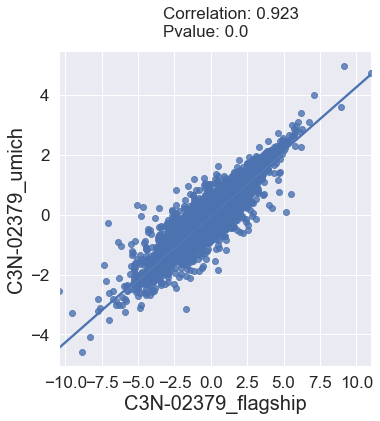

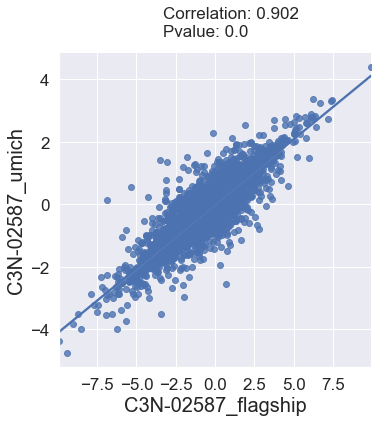

In [192]:
both = fdf.join(pcdf, how = 'inner')
both.head()
both

for col in both.columns:
    both[col] = pd.to_numeric(both[col])  

wrap_lin_reg(both, dup_list, y_lab = source_name)

In [193]:
print(omics)
get_corr(both, dup_list)

phospho


,Comparison,Correlation,P_value
0,C3N-02379,0.923970,0.000000e+00
0,C3N-02379.N,-0.260257,4.947635e-179
0,C3N-02587,0.902185,0.000000e+00
0,C3N-02587.N,-0.115274,3.526773e-42
